In [1]:
# IMPORTS
import matplotlib.pyplot as plt
import numpy as np
import glob, os, shutil,random
import tensorflow as tf
import cv2

from tensorflow.keras.preprocessing import image_dataset_from_directory

In [2]:
# IMPORTS
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dropout, Dense, BatchNormalization, Input, Lambda, Activation, Conv2D, MaxPooling2D, Reshape, Bidirectional, TimeDistributed, GRU
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, CSVLogger, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator


Here, we have imported the necessary librari function that is required for this model.

# Preparing Dataset for applying to the model

We created directories to the train, validation and test set. We have divided our whole dataset into 6:2:2.

In [3]:
# DIRECTORIES
DIRECTORY = '../input/mendeley-and-sdnet/Mixed_Dataset/'
TRAIN_DIR = os.path.join(DIRECTORY, 'train')
VAL_DIR = os.path.join(DIRECTORY, 'val')
TEST_DIR = os.path.join(DIRECTORY, 'test')


We defined some necessary hyperparameters. Batch size 32 is optimum. Otherwise, as our dataset is too long, it hinders the runtime. Same goes for learning rate. Smaller learning rate requires much more time.

In [4]:
# HYPERPARAMETERS
learning_rate = 0.0001
BATCH_SIZE = 32
IMG_SIZE = (224,224)
INPUT_SHAPE = (224, 224, 3)

We have assigned our image datas to respective variables for our model to use.

In [5]:
# ASSIGNING DATASET TO VARIABLE
TRAIN_IT = image_dataset_from_directory(TRAIN_DIR, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)
VAL_IT = image_dataset_from_directory(VAL_DIR, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)
TEST_IT = image_dataset_from_directory(TEST_DIR, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)

Found 33690 files belonging to 2 classes.
Found 12731 files belonging to 2 classes.
Found 12696 files belonging to 2 classes.


Even though we have more than enough data, data augmentation is applied to improve performance and reduce overfitting. Here, horizontal and vertical flip, and rotation is added as augmentation.

In [6]:
# DATA AUGMENTATION
DATA_AUG = tf.keras.Sequential([ tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.3) ])

Data visualtization before and after augmentation

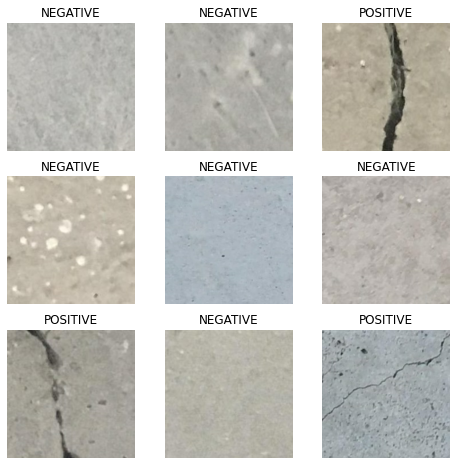

In [7]:
# DATA BEFORE AUGMENTATION
CLASSES = TRAIN_IT.class_names

plt.figure(figsize=(8, 8))
for images, labels in TRAIN_IT.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(CLASSES[labels[i]])
    plt.axis("off")

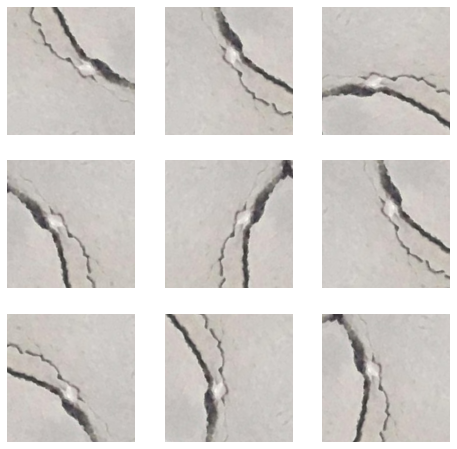

In [8]:
# DATA AFTER AUGMENTATION
for image, _ in TRAIN_IT.take(1):
  plt.figure(figsize=(8, 8))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    aug_img = DATA_AUG(tf.expand_dims(first_image, 0))
    plt.imshow(aug_img[0] / 255)
    plt.axis('off')

Here, prefetch is used to speed up the training process.

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

TRAIN_IT = TRAIN_IT.prefetch(buffer_size=AUTOTUNE)
VAL_IT = VAL_IT.prefetch(buffer_size=AUTOTUNE)
TEST_IT = TEST_IT.prefetch(buffer_size=AUTOTUNE)

# Building model
Our initial EfficientNetB0 model is structured using built in function. EffcientNetB0 belongs to the family of image processing deep learning models called EffciientNet. The baseline network of EfficientNet is designed using
multiobjective neural architecture search, and then, the baseline network is scaled in terms of depth, width, and resolution to achieve a balance among them.  They are unique and work better in feature extraction due to the usage of Mobile Inverted Bottleneck block, Squeeze and Excitation block, and swish activation function. 

In [10]:
INITIAL_MODEL = tf.keras.applications.efficientnet.EfficientNetB0(input_shape= INPUT_SHAPE, include_top=False, weights='imagenet')

16711680/16705208 [==============================] - 0s 0us/step


As we are using transfer learning as the paper suggested, first we freeze the layers of our initial model. In this way, our dataset will be trained on the pretrained weights of the ImageNet.

In [11]:
INITIAL_MODEL.trainable = False

In [12]:
INITIAL_MODEL.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
_____________________________________________________________________________________

For our final layer, we have used sigmoid activation function.

In [13]:
pred_layer = tf.keras.layers.Dense(1,activation='sigmoid')

Here, we have stacked all of our layers one by one.

In [14]:
input = tf.keras.Input(shape= INPUT_SHAPE)
x = DATA_AUG(input)
x = tf.keras.applications.efficientnet.preprocess_input(input)
x = INITIAL_MODEL(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D() (x)
x = tf.keras.layers.Dropout(0.3)(x)
output = pred_layer(x)
model = tf.keras.Model(input, output)

In [15]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate),loss=tf.keras.losses.BinaryCrossentropy(from_logits= False),
              metrics=['accuracy','Precision', 'Recall'])

In [16]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 4,050,852
Trainable params: 1,281
Non-trainable params: 4,049,571
_________________________________________________________________


# Training the model.
First, we are training the model on the pretrained weights of the ImageNet. 10 epochs are moderate. Too many causes the model to overfit and takes up too much runtime. Less epochs takes a toll on accuracy.

In [17]:
epochs = 10
history = model.fit(TRAIN_IT, epochs=epochs, validation_data=VAL_IT)

Epoch 1/10
1053/1053 [==============================] - 254s 230ms/step - loss: 0.4387 - accuracy: 0.8380 - precision: 0.8960 - recall: 0.7999 - val_loss: 0.1648 - val_accuracy: 0.9522 - val_precision: 0.9908 - val_recall: 0.9322
Epoch 2/10
1053/1053 [==============================] - 69s 65ms/step - loss: 0.1682 - accuracy: 0.9447 - precision: 0.9860 - recall: 0.9156 - val_loss: 0.1183 - val_accuracy: 0.9573 - val_precision: 0.9860 - val_recall: 0.9451
Epoch 3/10
1053/1053 [==============================] - 69s 65ms/step - loss: 0.1291 - accuracy: 0.9520 - precision: 0.9827 - recall: 0.9318 - val_loss: 0.1007 - val_accuracy: 0.9605 - val_precision: 0.9840 - val_recall: 0.9523
Epoch 4/10
1053/1053 [==============================] - 68s 64ms/step - loss: 0.1140 - accuracy: 0.9551 - precision: 0.9789 - recall: 0.9413 - val_loss: 0.0917 - val_accuracy: 0.9630 - val_precision: 0.9833 - val_recall: 0.9570
Epoch 5/10
1053/1053 [==============================] - 68s 65ms/step - loss: 0.1046 -

We have visualized the training and validation loss to find out if there is any overfitting.

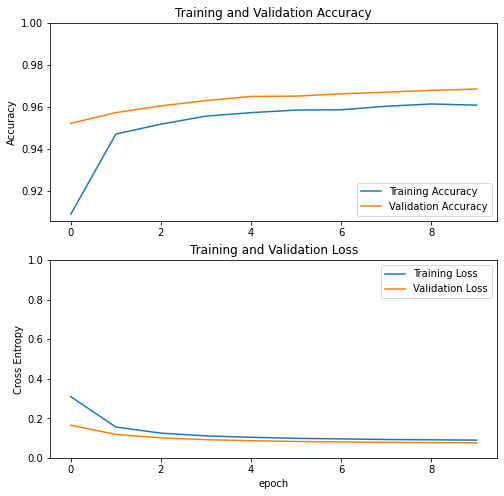

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Now we will stack some trainable layers to train the model according to our dataset.

In [19]:
INITIAL_MODEL.trainable = True

We are applying fine tuining on our model using 1/10th of our previous learning rate. Fine tuining will start from 100th layer, and previous layers will remain freeze. Only the layers after 100th will be trained. Here, 10 epochs are ran to offset between runtime and accuracy.

In [20]:
# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in INITIAL_MODEL.layers[:fine_tune_at]:
  layer.trainable =  False

In [21]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits= False), optimizer = tf.keras.optimizers.RMSprop(lr=learning_rate/10),
              metrics=['accuracy','Precision','Recall'])

In [22]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 4,050,852
Trainable params: 3,841,629
Non-trainable params: 209,223
_________________________________________________________________


In [23]:
fine_tune_epochs = 10
total_epochs =  epochs + fine_tune_epochs

history_fine = model.fit(TRAIN_IT,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=VAL_IT)

Epoch 10/20
1053/1053 [==============================] - 125s 108ms/step - loss: 0.0750 - accuracy: 0.9676 - precision: 0.9786 - recall: 0.9639 - val_loss: 0.0500 - val_accuracy: 0.9793 - val_precision: 0.9937 - val_recall: 0.9730
Epoch 11/20
1053/1053 [==============================] - 112s 106ms/step - loss: 0.0559 - accuracy: 0.9764 - precision: 0.9853 - recall: 0.9730 - val_loss: 0.0449 - val_accuracy: 0.9806 - val_precision: 0.9905 - val_recall: 0.9784
Epoch 12/20
1053/1053 [==============================] - 113s 107ms/step - loss: 0.0501 - accuracy: 0.9800 - precision: 0.9878 - recall: 0.9768 - val_loss: 0.0435 - val_accuracy: 0.9815 - val_precision: 0.9882 - val_recall: 0.9820
Epoch 13/20
1053/1053 [==============================] - 113s 107ms/step - loss: 0.0470 - accuracy: 0.9817 - precision: 0.9885 - recall: 0.9792 - val_loss: 0.0420 - val_accuracy: 0.9826 - val_precision: 0.9917 - val_recall: 0.9803
Epoch 14/20
1053/1053 [==============================] - 113s 107ms/step - l

Visualization of training and validation loss.

In [24]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

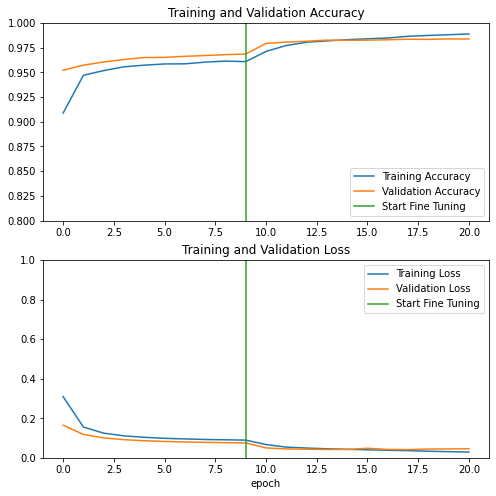

In [25]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([epochs-1,epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([epochs-1,epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Evaluation of the model.
Evaluation metrics are accuracy, precision, recall and f1 score.

In [26]:
loss, accuracy, precision, recall = model.evaluate(TEST_IT)
print('Test accuracy :', accuracy)
print('Test precision :', precision)
print('Test recall :', recall)

397/397 [==============================] - 74s 183ms/step - loss: 0.0452 - accuracy: 0.9842 - precision: 0.9930 - recall: 0.9817
Test accuracy : 0.9842470288276672
Test precision : 0.9929811358451843
Test recall : 0.9817057847976685


In [27]:
f1_score = (2*precision*recall)/(precision+recall)
print('F1 Score : ', f1_score)

F1 Score :  0.9873112695118567


A batch of image from our testing dataset is shown after prediction.

Predictions:
 [1 0 0 0 1 1 0 0 0 0 1 1 1 1 0 0 1 0 1 1 0 0 0 1 1 0 1 1 0 1 1 1]
Labels:
 [1 0 0 0 1 1 0 0 1 0 1 1 1 1 0 0 1 0 1 1 0 1 0 1 1 1 1 1 0 1 1 1]


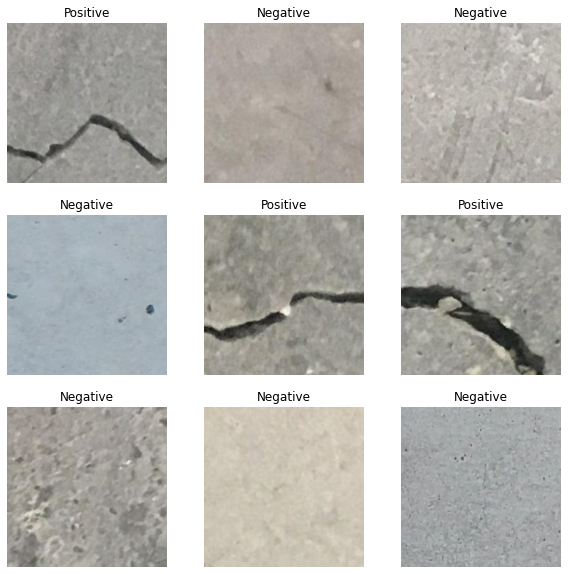

In [28]:
#Retrieve a batch of images from the test set
image_batch, label_batch = TEST_IT.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()
class_names = ['Negative', 'Positive']
# Apply a sigmoid since our model returns logits
#predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

# Saving the weights of the model for future use.

In [29]:
model.save_weights("efficientnet_concrete_crack_detection")